In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import meshio
from pathlib import Path


import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap, random
import optax
from tqdm.auto import tqdm
from typing import Callable
import pickle
import equinox as eqx

import os

from triangular_transport.flows.flow_trainer import (
    NNTrainer, KernelTrainer
)

from triangular_transport.flows.interpolants import (
    linear_interpolant,
    linear_interpolant_der,
    trig_interpolant,
    trig_interpolant_der,
    sigmoid_interpolant,
    sigmoid_interpolant_der,
)
from triangular_transport.flows.loss_functions import kernel_vec_field_loss
from triangular_transport.flows.methods.utils import UnitGaussianNormalizer
from triangular_transport.flows.dataloaders import gaussian_reference_sampler
from triangular_transport.kernels.kernel_tools import get_matern_5_2, get_gaussianRBF, get_sum_of_kernels, linear_kernel

import json
import h5py

import argparse

plt.style.use("ggplot")

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
jax.config.update("jax_default_device", jax.devices()[1])

In [2]:
def read_data_h5(path="data.h5"):
    with h5py.File(path, "r") as f:
        targets = f["/target"][...]
        data = f["/data"][...]
    return targets, data

In [3]:
with open("poisson.yaml") as fid:
    inargs = yaml.full_load(fid)

utrue = np.load("training_dataset/true_param_grid.npy")
ytrue = np.load("training_dataset/true_state_grid.npy")
map_est = np.load("training_dataset/map_param_grid.npy")
targets, yobs = read_data_h5()

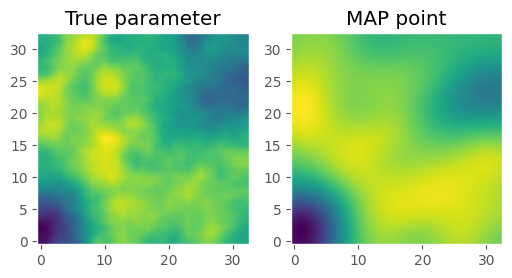

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(6,6))

ax[0].imshow(utrue, origin="lower", interpolation="bilinear")
ax[0].set_title("True parameter")
ax[0].grid(False)

ax[1].imshow(map_est, origin="lower", interpolation="bilinear")
ax[1].set_title("MAP point")
ax[1].grid(False)

In [17]:
nsamples = inargs["MCMC"]["nsamples"] - inargs["MCMC"]["burnin"]

hmala_samps = np.load("training_dataset/chain_30/hmala_samples_grid_delta.npy").reshape(nsamples, 33, 33)
hmala_mean = np.mean(hmala_samps, axis=0)
hmala_var = np.var(hmala_samps, axis=0)

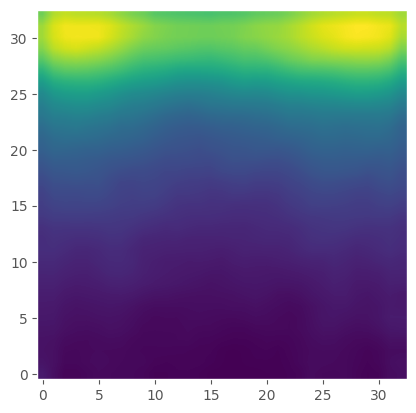

In [18]:
plt.imshow(hmala_var, origin="lower", interpolation="bilinear")
plt.grid(False)

In [26]:
train_dim = 50000
nx = ny = 33
flat_length = nx * ny
ys = (np.load("training_dataset/solutions_grid_delta.npy"))[:train_dim]
us = (np.load("training_dataset/parameters_delta.npy"))[:train_dim, :].reshape(train_dim, flat_length)

us_ref = us.copy()
np.random.shuffle(us_ref)

us_test = (np.load("training_dataset/parameters_delta.npy"))[train_dim:train_dim + 20000, :].reshape(20000, flat_length)
np.random.shuffle(us_test)

ys_normalizer = UnitGaussianNormalizer(ys)
ys_normalized = ys_normalizer.encode()

In [27]:
mean_us = us.mean(axis=0)
X = us - mean_us

U, S, Vt = np.linalg.svd(us / (np.sqrt(train_dim - 1)), full_matrices=False)
V = Vt.T

expl_var = (S**2) / (S**2).sum()
k = np.searchsorted(np.cumsum(expl_var), 0.98) + 1
# k = 30

V = V[:, :k]
S = S[:k]

alpha = 0.1


def pca_encode(b):
    # whitened coeffs z
    return (b - mean_us) @ V / S


def pca_decode(z):
    # undo whitening
    return mean_us + (z * S) @ V.T

In [28]:
us_pca = pca_encode(us)
us_ref_pca = pca_encode(us_ref)
us_test_pca = pca_encode(us_test)

target_data = jnp.hstack([ys_normalized, us_pca])
ref_data = jnp.hstack([ys_normalized, us_ref_pca])

In [29]:
yu_dimension = (ys.shape[1], us_pca.shape[1])
lam = 0.03
gammas = 12.0 * jnp.ones(np.sum(yu_dimension).item() + 1) # 10.0 worked great here!
gammas1 = 10.0 * jnp.ones(np.sum(yu_dimension).item() + 1)
gammas2 = 8.0 * jnp.ones(np.sum(yu_dimension).item() + 1)
# gammas = 2 * random.lognormal(key=random.PRNGKey(23), sigma=1.0, shape=23)
matern_args = {"gamma": gammas}
matern1_args = {"gamma": gammas1}
matern2_args = {"gamma": gammas2}

train_dim = target_data.shape[0]
num_pivots = 1000
batch_size = 1000
test_batch_size = 5000
num_batches = 3000
k1 = get_matern_5_2(**matern_args) # TODO: Change this to matern_1_2
# k2 = get_matern_5_2(**matern1_args)
# k3 = get_matern_5_2(**matern2_args)
k2 = get_gaussianRBF(8.0)
k3 = get_gaussianRBF(10.0)
k4 = get_gaussianRBF(12.0)
kernels = [k1, k2, k3, k4]
c1 = [0.5, 0.2, 0.2, 0.1]
k = get_sum_of_kernels(kernels, c1)

interpolant = linear_interpolant
interpolant_der = linear_interpolant_der
interpolant_args = {"t": None, "x1": None, "x0": None}

def model():
    pass

In [30]:
b_model = KernelTrainer(
    target_density=None,
    model=model,
    optimizer=optax.adam(1e-5),
    interpolant=interpolant,
    interpolant_der=interpolant_der,
    reference_sampler=gaussian_reference_sampler,
    loss=kernel_vec_field_loss,
    interpolant_args=interpolant_args,
    seed=43,
    yu_dimension=yu_dimension,
    cond=True,
)
b_model.train(
    x1_data=target_data,
    x0_data=ref_data,
    train_dim=train_dim,
    num_pivots=num_pivots,
    batch_size=batch_size,
    num_batches=num_batches,
    lam=lam,
    k=k,
    num_M_iters=1,
);

Picking pivots through Partial Cholesky


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Performing Nyström approximation


  0%|          | 0/3000 [00:00<?, ?it/s]

In [31]:
no_samples = inargs["MCMC"]["nsamples"] - inargs["MCMC"]["burnin"]
ytrue_flat = yobs.copy()
ytrue_flat_normalized = ys_normalizer.encode(ytrue_flat)
ys_test_normalized = jnp.full(
    (no_samples, ytrue_flat_normalized.shape[0]), ytrue_flat_normalized
)
x0_test = jnp.hstack([ys_test_normalized, us_test_pca])
# x0_test = jnp.hstack([ys_test_normalized, us_test])

cond_values = [tuple(ytrue_flat_normalized)]
cond_samples = b_model.conditional_sample(
    cond_values=cond_values, x0_cond=x0_test, nsamples=20000
)
all_samples = cond_samples[0][0]

u_samples = all_samples[:, yu_dimension[0] :]
u_samples = pca_decode(u_samples)
u_samples = u_samples.reshape(no_samples, nx, ny)
u_means = jnp.mean(u_samples, axis=0)
u_var = jnp.var(u_samples, axis=0)

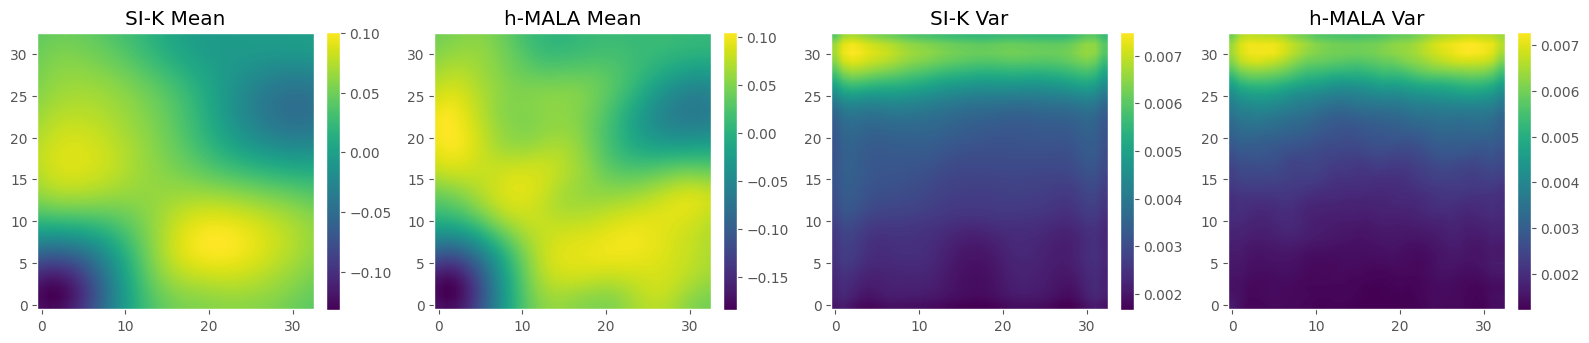

In [32]:
layer_idx = 0
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

im0 = ax[0].imshow(u_means, origin="lower", interpolation="bilinear")
ax[0].set_title("SI-K Mean")
ax[0].grid(False)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(
    hmala_mean, origin="lower", interpolation="bilinear"
)
ax[1].set_title("h-MALA Mean")
ax[1].grid(False)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(u_var, origin="lower", interpolation="bilinear")
ax[2].set_title("SI-K Var")
ax[2].grid(False)
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

im3 = ax[3].imshow(hmala_var, origin="lower", interpolation="bilinear")
ax[3].set_title("h-MALA Var")
ax[3].grid(False)
fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()